In [1]:
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel, set_cmdstan_path
from pathlib import Path

import arviz

import matplotlib.pyplot as plt

In [2]:
def is_incident_smoker(arr):
    arr = arr.values
    if len(arr) == 1 or arr[0] == 1:
        return False
    try:
        first_idx = np.argwhere(arr == 1)[0][0]
        return np.mean(arr[first_idx : len(arr)]) == 1
    except IndexError as ex:
        return False

In [3]:
def calculate_incident_smokers_test_statistic(
    y_pred, df_y_rep, is_incident_smoker
):
    ts = []
    for i in range(y_pred.shape[0]):
        tmp_df = pd.DataFrame(
            {"smkreg": y_pred[i], "newid": df_y_rep["newid"]}
        )
        ts.append(
            np.mean(tmp_df.groupby("newid")["smkreg"].agg(is_incident_smoker))
        )
    return ts

In [4]:
def plot_ppc_hist(
    ax,
    test_statistic,
    test_statistic_y,
    quantiles,
    p_value,
    vline_height,
    bins=25,
):
    ax.hist(test_statistic, bins=bins, color="#fa7268")
    ax.vlines(quantiles[0], 0, vline_height, linestyle="--", color="grey")
    ax.vlines(quantiles[1], 0, vline_height, linestyle="--", color="grey")
    ax.vlines(
        test_statistic_y,
        0,
        vline_height,
        linestyle="--",
        label="$T(y)$",
    )
    ax.set_title(
        f"p-value: {p_value:.3f} \n Test statistic y_rep 95% int: [{quantiles[0]*100:.1f}, {quantiles[1]*100:.1f}] \n Test statistic y: {test_statistic_y*100:.1f}"
    )

### Load data

In [5]:
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

In [6]:
smoking_data = pd.read_table("../utilities_and_data/smoking/smoke_pub.dat")
num_people = smoking_data["newid"].nunique()
smoking_data["mean_waves_smoked"] = smoking_data.groupby("newid")[
    "smkreg"
].transform("mean")

never_smokers_test_statistic_y = (
    smoking_data.groupby("newid")["smkreg"].agg("mean") == 0
).mean()
always_smokers_test_statistic_y = (
    smoking_data.groupby("newid")["smkreg"].agg("mean") == 1
).mean()

incident_smokers_test_statistic_y = np.mean(
    smoking_data.groupby("newid")["smkreg"].agg(is_incident_smoker)
)

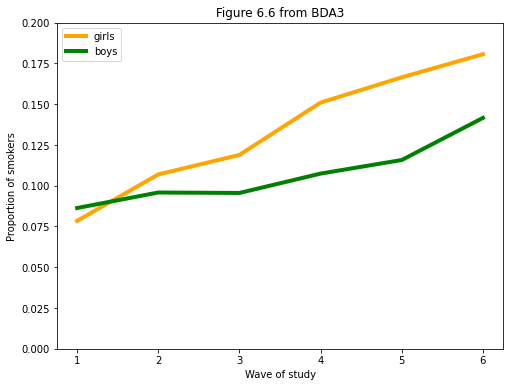

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    smoking_data.loc[smoking_data["sex(1=F)"] == 1]
    .groupby("wave")["smkreg"]
    .mean(),
    label="girls",
    color="orange",
    linewidth=4,
)
ax.plot(
    smoking_data.loc[smoking_data["sex(1=F)"] == 0]
    .groupby("wave")["smkreg"]
    .mean(),
    label="boys",
    color="green",
    linewidth=4,
)
ax.set_ylim(0, 0.2)
ax.set_xlabel("Wave of study")
ax.set_ylabel("Proportion of smokers")
ax.legend()
ax.set_title("Figure 6.6 from BDA3");

### Data

In [8]:
stan_data = {
    "N_people": num_people,
    "N": len(smoking_data),
    "parent_smoke": smoking_data["parsmk"].values.astype(int),
    "female": smoking_data["sex(1=F)"].values.astype(int),
    "t": smoking_data["wave"].values.astype(int),
    "smoke": smoking_data["smkreg"].values.astype(int),
    "p_idx": smoking_data["newid"].values.astype(int),
}

### Model 1

In [8]:
model = CmdStanModel(stan_file="stan_models/smoking.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/maw501/ML/maw501_github/BDA_py_demos/demos_ch6/stan_models/smoking


In [10]:
fit = model.sample(
    data=stan_data,
    output_dir=output_dir,
    iter_warmup=1_000,
    iter_sampling=1_000,
    # show_progress="notebook",
)

In [11]:
params = fit.stan_variables()
var_names = ["b0", "b1", "b2", "b3", "b4", "sigma_alpha"]

In [12]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data, var_names=var_names)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

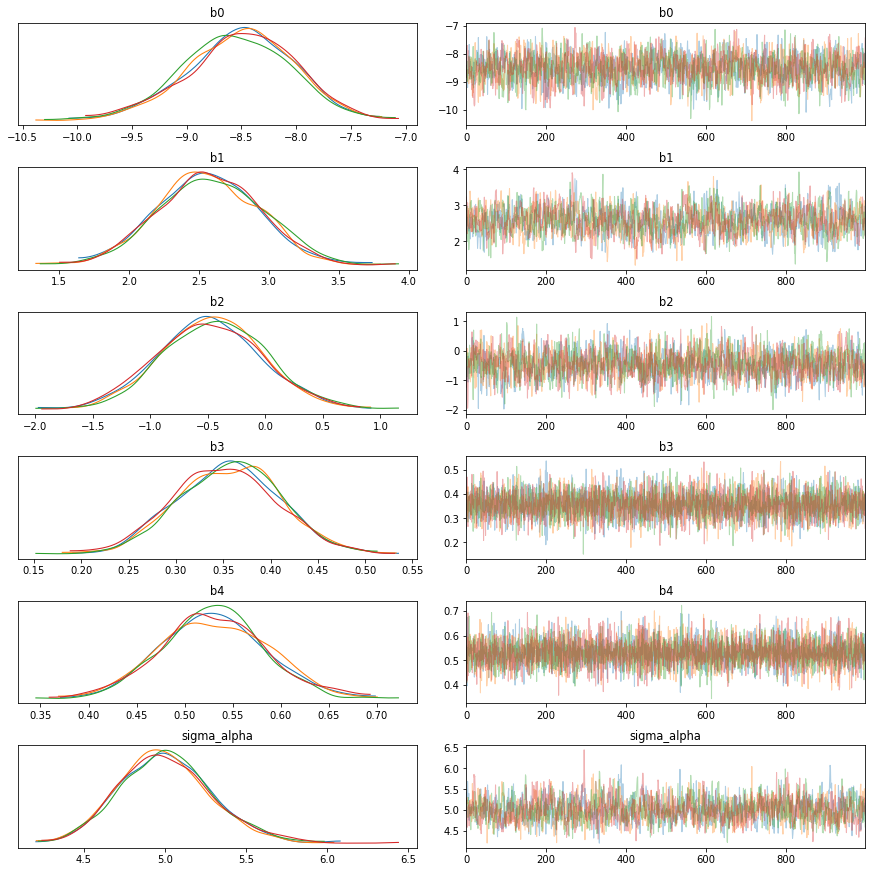

In [13]:
arviz.plot_trace(fit, var_names=var_names);

### Posterior predictive checking

In [14]:
df_y_rep = pd.DataFrame(params["y_pred"]).T
df_y_rep["newid"] = smoking_data["newid"].values
df_y_rep_mean_per_person = df_y_rep.groupby("newid").mean().values

In [15]:
qs = [0.025, 0.975]

never_smokers_test_statistic = (df_y_rep_mean_per_person == 0).mean(0)
never_smokers_quantiles = np.quantile(never_smokers_test_statistic, q=qs)

always_smokers_test_statistic = (df_y_rep_mean_per_person == 1).mean(0)
always_smokers_quantiles = np.quantile(always_smokers_test_statistic, q=qs)

incident_smokers_test_statistic = calculate_incident_smokers_test_statistic(
    params["y_pred"].values, df_y_rep, is_incident_smoker
)
incident_smokers_quantiles = np.quantile(incident_smokers_test_statistic, q=qs)

In [16]:
never_smokers_p_value = np.mean(
    never_smokers_test_statistic > never_smokers_test_statistic_y
)
always_smokers_p_value = np.mean(
    always_smokers_test_statistic > always_smokers_test_statistic_y
)
incident_smokers_p_value = np.mean(
    incident_smokers_test_statistic > incident_smokers_test_statistic_y
)

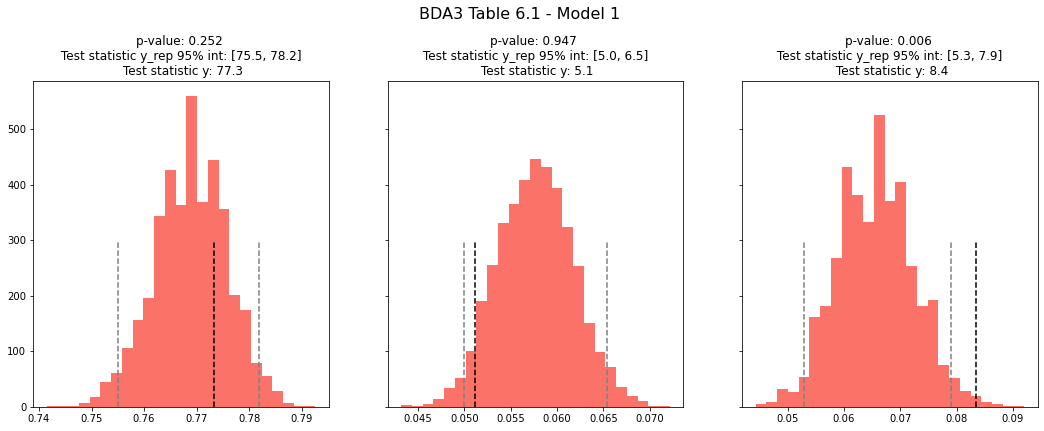

In [29]:
bins = 25
vline_height = 300

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_ppc_hist(
    ax[0],
    never_smokers_test_statistic,
    never_smokers_test_statistic_y,
    never_smokers_quantiles,
    never_smokers_p_value,
    vline_height,
)
plot_ppc_hist(
    ax[1],
    always_smokers_test_statistic,
    always_smokers_test_statistic_y,
    always_smokers_quantiles,
    always_smokers_p_value,
    vline_height,
)
plot_ppc_hist(
    ax[2],
    incident_smokers_test_statistic,
    incident_smokers_test_statistic_y,
    incident_smokers_quantiles,
    incident_smokers_p_value,
    vline_height,
)

plt.suptitle("BDA3 Table 6.1 - Model 1", y=1.05, fontsize=16);

### Model 2: mixture model

Repeat the above analysis for a mixture model now.

In [16]:
model_mix = CmdStanModel(stan_file="stan_models/smoking_mixture.stan")

INFO:cmdstanpy:compiling stan program, exe file: /project/mark/BDA3-python-demos/demos_ch6/stan_models/smoking_mixture
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /project/mark/BDA3-python-demos/demos_ch6/stan_models/smoking_mixture


In [17]:
fit_mix = model_mix.sample(
    data=stan_data,
    output_dir=output_dir,
    iter_warmup=1_000,
    iter_sampling=1_000,
    show_progress="notebook",
)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
params_mix = fit_mix.stan_variables()

In [19]:
var_names_mix = [
    "b0",
    "b1",
    "b2",
    "b3",
    "b4",
    "gamma_0",
    "gamma_1",
    "gamma_2",
    "sigma_alpha",
    #"tau",
]

In [20]:
inference_data_mix = arviz.convert_to_inference_data(fit_mix)

summary_df_mix = (
    arviz.summary(inference_data_mix, var_names=var_names_mix)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [21]:
summary_df_mix.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b0,-10.307,0.963,-12.118,-8.548,0.050,0.035,375.0,372.0,374.0,947.0,1.01
1,b1,3.016,0.535,2.038,3.998,0.027,0.019,392.0,385.0,396.0,987.0,1.01
2,b2,-0.829,0.640,-1.993,0.419,0.021,0.015,921.0,921.0,921.0,1716.0,1.00
3,b3,0.507,0.096,0.331,0.692,0.003,0.002,848.0,848.0,854.0,1796.0,1.00
4,b4,0.686,0.089,0.521,0.848,0.004,0.003,560.0,560.0,539.0,1106.0,1.01
5,gamma_0,1.109,0.298,0.571,1.650,0.010,0.007,869.0,863.0,890.0,1279.0,1.00
6,gamma_1,1.054,0.693,0.044,2.013,0.052,0.040,177.0,149.0,350.0,268.0,1.01
7,gamma_2,1.188,0.664,0.285,2.147,0.053,0.042,159.0,127.0,379.0,237.0,1.01
8,sigma_alpha,6.790,0.715,5.452,8.110,0.039,0.027,344.0,344.0,334.0,624.0,1.01


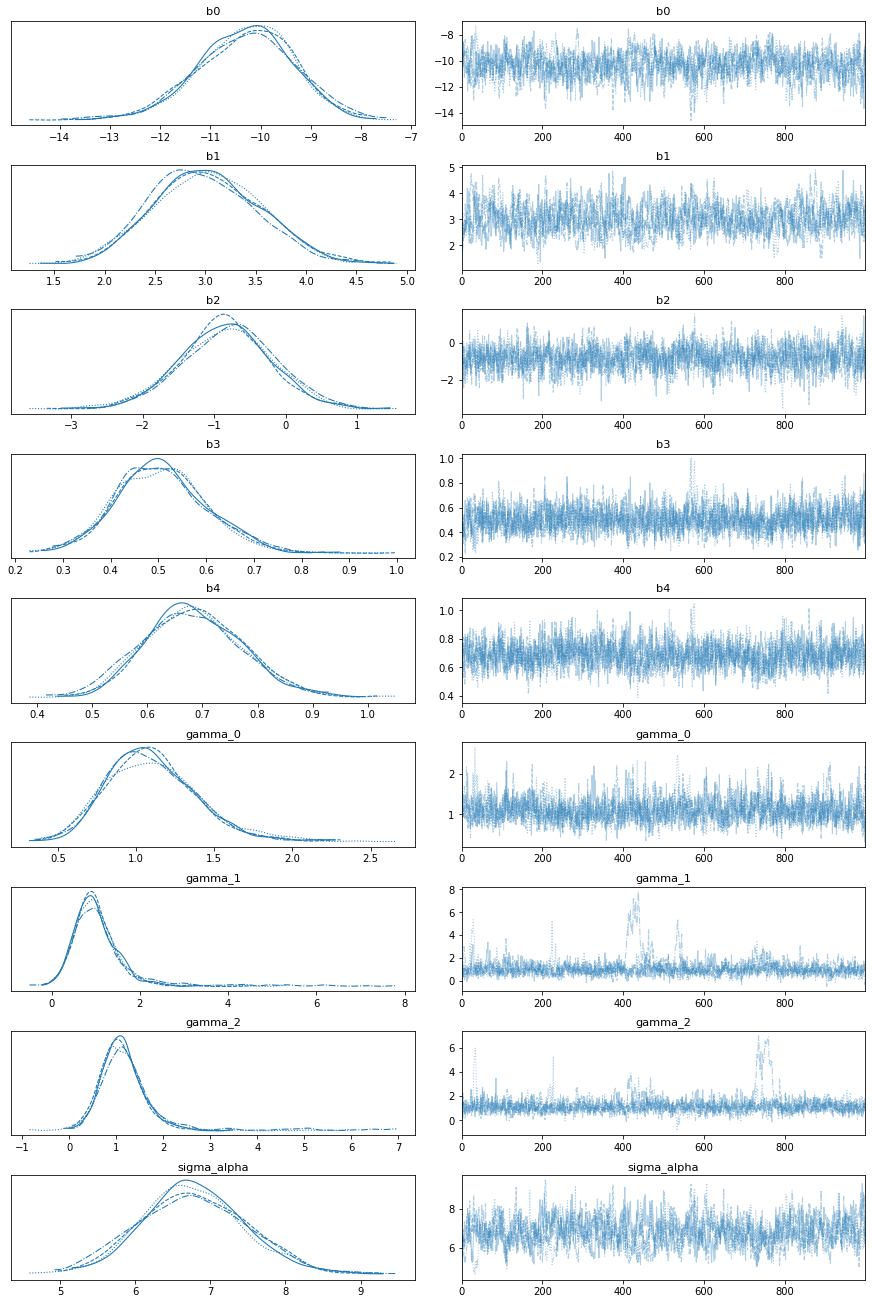

In [22]:
arviz.plot_trace(fit_mix, var_names=var_names_mix);

In [23]:
df_y_rep_mix = pd.DataFrame(params_mix["y_pred"]).T
df_y_rep_mix["newid"] = smoking_data["newid"].values
df_y_rep_mean_per_person_mix = df_y_rep_mix.groupby("newid").mean().values

qs = [0.025, 0.975]

In [24]:
never_smokers_test_statistic_mix = (df_y_rep_mean_per_person_mix == 0).mean(0)
never_smokers_quantiles_mix = np.quantile(
    never_smokers_test_statistic_mix, q=qs
)

always_smokers_test_statistic_mix = (df_y_rep_mean_per_person_mix == 1).mean(0)
always_smokers_quantiles_mix = np.quantile(
    always_smokers_test_statistic_mix, q=qs
)

incident_smokers_test_statistic_mix = (
    calculate_incident_smokers_test_statistic(
        params_mix["y_pred"].values, df_y_rep_mix, is_incident_smoker
    )
)
incident_smokers_quantiles_mix = np.quantile(
    incident_smokers_test_statistic_mix, q=qs
)

In [25]:
never_smokers_p_value_mix = np.mean(
    never_smokers_test_statistic_mix > never_smokers_test_statistic_y
)
always_smokers_p_value_mix = np.mean(
    always_smokers_test_statistic_mix > always_smokers_test_statistic_y
)
incident_smokers_p_value_mix = np.mean(
    incident_smokers_test_statistic_mix > incident_smokers_test_statistic_y
)

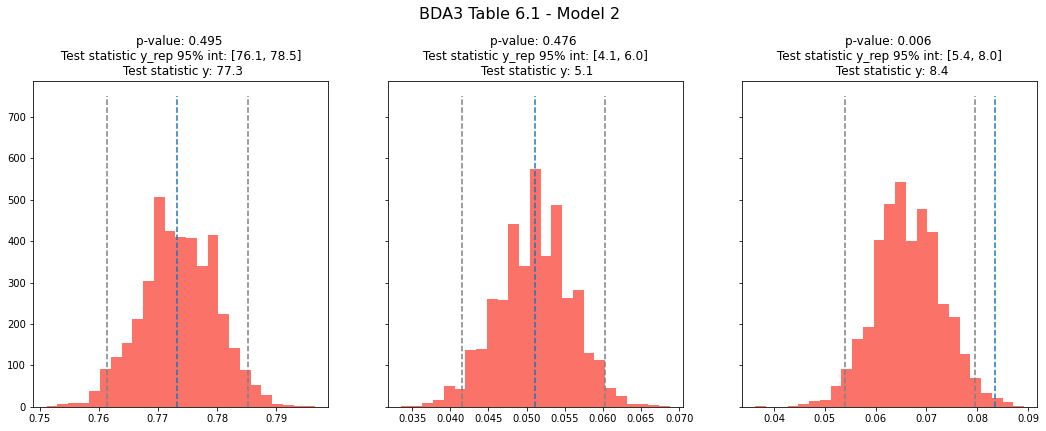

In [26]:
bins = 25
vline_height = 750

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_ppc_hist(
    ax[0],
    never_smokers_test_statistic_mix,
    never_smokers_test_statistic_y,
    never_smokers_quantiles_mix,
    never_smokers_p_value_mix,
    vline_height,
)
plot_ppc_hist(
    ax[1],
    always_smokers_test_statistic_mix,
    always_smokers_test_statistic_y,
    always_smokers_quantiles_mix,
    always_smokers_p_value_mix,
    vline_height,
)
plot_ppc_hist(
    ax[2],
    incident_smokers_test_statistic_mix,
    incident_smokers_test_statistic_y,
    incident_smokers_quantiles_mix,
    incident_smokers_p_value_mix,
    vline_height,
)

plt.suptitle("BDA3 Table 6.1 - Model 2", y=1.05, fontsize=16);